In [29]:
# Set manual seed for reproducibility
torch.manual_seed(10)

In [85]:
# Root directory for dataset (assuming this folder has class 0 removed)
# if that assumption is wrong:
# import shutil
# shutil.rmtree("symbols_dataset/class_0")
dataroot = "Q4_dataset"

# Batch size during training
batch_size = 128

# Image resize dimention
image_size = 64

# Size of z latent vector
latent_space = 80

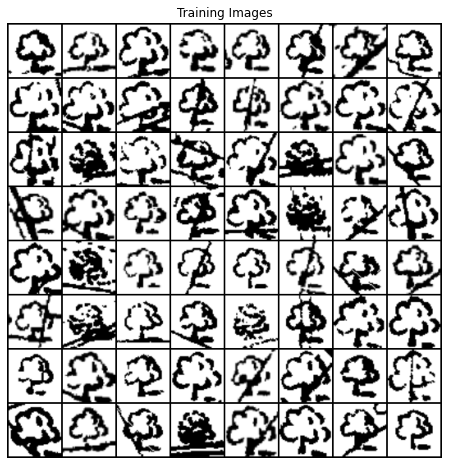

In [86]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor()])

dataset = ImageFolder(root=dataroot, transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [88]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(latent_space, 512, 4, 1, 0, bias=False), # Mapping the latent space to the feature map in the convolution layer
            nn.BatchNorm2d(512),
            nn.ReLU(True),   # 512 x 4 x 4
            
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),   # 256 x 8 x 8
            
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),   # 128 x 16 x 16
            
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),   # 64 x 32 x 32
            
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()   # 1 x 64 x 64
            
        )

    def forward(self, input):
        return self.main(input)

In [89]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),   # 1 x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),   # 64 x 32 x 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),   # 128 x 16 x 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),    # 256 x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),    # 512 x 4 x 4
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [142]:
# Initializing the models

def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

Generator_network = Generator().to(device)
Generator_network.apply(weights_init)

Discriminator_network = Discriminator().to(device)
Discriminator_network.apply(weights_init)

print(Generator_network)
print(Discriminator_network)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(80, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
D

In [143]:
# Learning rate for optimisers
lr = 0.0002

loss = nn.BCELoss()

# Setup Adam optimizers for models
Discriminator_optimizer = optim.Adam(Discriminator_network.parameters(), lr=lr, betas=(0.5, 0.999))
Generator_optimizer = optim.Adam(Generator_network.parameters(), lr=lr, betas=(0.5, 0.999))

In [144]:
# Number of training epochs
epochs = 5

# Lists to keep track of progress
G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

        # Discriminator Training
        # Train with real data

        Discriminator_network.zero_grad()
        real_data = data[0].to(device)
        data_size = real_data.size(0)
        labels = torch.full((data_size,), 1, dtype=torch.float, device=device)
        results_real = Discriminator_network(real_data).view(-1)
        Discriminator_error_real = loss(results_real, labels)
        Discriminator_error_real.backward()

        # Train with fake data
        
        noise = torch.randn(data_size, latent_space, 1, 1, device=device)
        fake_data = Generator_network(noise)
        labels.fill_(0)
        results_fake = Discriminator_network(fake_data.detach()).view(-1)
        Discriminator_error_fake = loss(results_fake, labels)
        Discriminator_error_fake.backward()
        total_Discriminator_error = Discriminator_error_real + Discriminator_error_fake
        Discriminator_optimizer.step()

        # Generator Training
        
        Generator_network.zero_grad()
        labels.fill_(1)
        generated_fake = Discriminator_network(fake_data).view(-1)
        Generator_error = loss(generated_fake, labels)
        Generator_error.backward()
        Generator_optimizer.step()

        # Printing out the losses
        if i == 44 or i == 0 or ((epoch == epochs-1) and (i == (len(dataloader)-1))):
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t' % (epoch+1, epochs, i+1, len(dataloader), total_Discriminator_error.item(), Generator_error.item()))

        # Save Losses for each batch to plot 
        G_losses.append(Generator_error.item())
        D_losses.append(total_Discriminator_error.item())

[1/5][1/85]	Loss_D: 2.4631	Loss_G: 1.7873	
[1/5][45/85]	Loss_D: 1.6358	Loss_G: 24.9923	
[2/5][1/85]	Loss_D: 0.8370	Loss_G: 10.1675	
[2/5][45/85]	Loss_D: 1.0385	Loss_G: 13.4602	
[3/5][1/85]	Loss_D: 0.3557	Loss_G: 4.3068	
[3/5][45/85]	Loss_D: 0.1457	Loss_G: 4.3372	
[4/5][1/85]	Loss_D: 1.4616	Loss_G: 15.3860	
[4/5][45/85]	Loss_D: 0.6626	Loss_G: 10.0318	
[5/5][1/85]	Loss_D: 0.1555	Loss_G: 5.2154	
[5/5][45/85]	Loss_D: 0.0642	Loss_G: 2.3377	
[5/5][85/85]	Loss_D: 0.2845	Loss_G: 3.0846	


The reasons I chose to use a DCGAN network architecture is because it is a more stable architecture thefore it produces more consistant as well as better quality results. It also uses bach normalisation instead of maxpooling and leakyRelu to avoid sparse gradients which increases stability of the network. I used strided convolutional layers rather than pooling layers to downsample because it allows the network more freedom in terms of learning its own pooling function. It's important to note that I could'ved used SGD as the optimiser for the discriminator as it's believed to help with stability but as I don't see that being an issue I chose to use ADAM for both as it gives the best results. I chose to use the number of feature maps in both the generator and discriminator layers as I believe the features in the data aren't that complext therefore doesn't need a super deep network with a large amount of complexity in the layers. Before the training begins, the DCGAN paper authors say to initialise all the weights in the convolutional, convolutional-transpose and batch normalisation layers in the generator and discriminator networks randomly from a normal distribution with a mean if 0 and a standard deviation of 0.02 which is what the weights_init function does. In the training the discriminator I run a forward pass with a batch of the real data and calcuate the gradients in a backward pass then do the same thing with a batch of generated fake data using the current generator then compute the gradient as the total sum of gradients from the fake and real data and use that to update the discriminator using the optimiser I defined previously for it, essentially for the discriminator I'm trying to maximise Log(D(x)) + Log(1 - D(G(z))). For the genrator I'm just trying to maximise Log(D(G(z))), as opposed to trying to minimise Log(1 - D(G(z))) as it was proven to not produce enough gradients especially in the beginning of training, and I do that by running the fake data through the discriminator again but this time with all of it labeled as real data and update the generator's loss using that output and calculate the gradients for it as well and then run the optimiser step. 

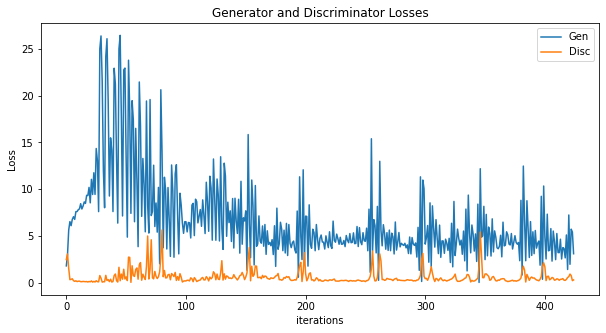

In [145]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses")
plt.plot(G_losses,label="Gen")
plt.plot(D_losses,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [146]:
noise = torch.randn(64, latent_space, 1, 1, device=device)
with torch.no_grad():
    fake = Generator_network(noise).detach().cpu()
final_output = vutils.make_grid(fake, padding=2, normalize=True)

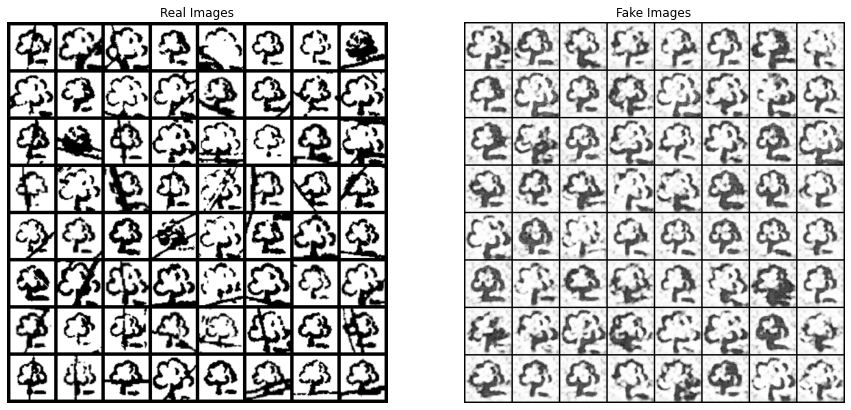

In [147]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(final_output,(1,2,0)))
plt.show()

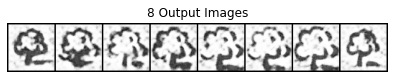

In [154]:
noise = torch.randn(8, latent_space, 1, 1, device=device)
with torch.no_grad():
    fake = Generator_network(noise).detach().cpu()
output = vutils.make_grid(fake, padding=2, normalize=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("8 Output Images")
plt.imshow(np.transpose(output,(1,2,0)))

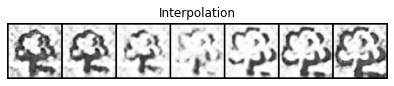

In [151]:
noise = torch.randn(2, latent_space, 1, 1).cpu()
steps = torch.tensor(np.logspace(noise[0],noise[1], 7)).to(device)
with torch.no_grad():
    fake = Generator_network(steps).detach().cpu()
output = vutils.make_grid(fake, padding=2, normalize=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Interpolation")
plt.imshow(np.transpose(output.cpu(),(1,2,0)))

In [150]:
torch.save(Generator_network.state_dict(), "Generator_weights.pkl")
torch.save(Discriminator_network.state_dict(), "Discriminator_weights.pkl")